In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/envs/tf2-gp

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent

from odcd.models.losses import loss_adv_vae
from odcd.ad import AdversarialVAE
from odcd.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from odcd.utils.visualize import plot_instance_score

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score

import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

In [4]:
def load_signs(train_folder="../data/traffic/train/"):
    
    data=[]
    labels=[]

    height = 30
    width = 30
    channels = 3
    classes = 43
    n_inputs = height * width*channels

    for i in range(classes) :
        path = train_folder+"{0}/".format(i)
        print(path)
        Class=os.listdir(path)
        for a in Class:
            try:
                image=cv2.imread(path+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
                labels.append(i)
            except AttributeError:
                print(" ")
            
    Cells=np.array(data)
    labels=np.array(labels)

    #Randomize the order of the input images
    s=np.arange(Cells.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    Cells=Cells[s]
    labels=labels[s]

    (X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]

    (y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]
    
    train, test = (X_train, y_train), (X_val, y_val)
    
    return train, test

In [5]:
train, test = load_signs()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 30, 30, 3).astype('float32') / 255
X_test = X_test.reshape(-1, 30, 30, 3).astype('float32') / 255
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#classes = ('0', '1', '2', '3',
#           '4', '5', '6', '7', '8', '9')
img_shape = (28, 28)


../data/traffic/train/0/
../data/traffic/train/1/
../data/traffic/train/2/
../data/traffic/train/3/
../data/traffic/train/4/
../data/traffic/train/5/
../data/traffic/train/6/
../data/traffic/train/7/
../data/traffic/train/8/
../data/traffic/train/9/
../data/traffic/train/10/
../data/traffic/train/11/
../data/traffic/train/12/
../data/traffic/train/13/
../data/traffic/train/14/
../data/traffic/train/15/
../data/traffic/train/16/
../data/traffic/train/17/
../data/traffic/train/18/
../data/traffic/train/19/
../data/traffic/train/20/
../data/traffic/train/21/
../data/traffic/train/22/
../data/traffic/train/23/
../data/traffic/train/24/
../data/traffic/train/25/
../data/traffic/train/26/
../data/traffic/train/27/
../data/traffic/train/28/
../data/traffic/train/29/
../data/traffic/train/30/
../data/traffic/train/31/
../data/traffic/train/32/
../data/traffic/train/33/
../data/traffic/train/34/
../data/traffic/train/35/
../data/traffic/train/36/
../data/traffic/train/37/
../data/traffic/train/

Sample instance from the MNIST data set.


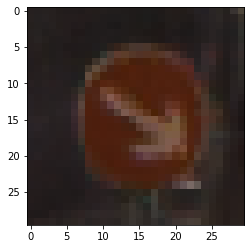

In [6]:
idx = 4200
x = X_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the MNIST data set.')

In [7]:
load_signs_model = True

In [8]:
filepath = './model_signs/'
if load_signs_model:
    model = load_tf_model(filepath)
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(43, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=5,
              batch_size=256,
              verbose=0,
              validation_data=(X_test, y_test)
              )
    
    # save model
    save_tf_model(model, filepath)

In [9]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.3305 -- accuracy: 0.9239


In [10]:
load_adversarial_detector = True

In [11]:
filepath = './ad_vae_signs/'
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = 50
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(30, 30, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(15*15*30, activation=tf.nn.relu),
          Reshape(target_shape=(15, 15, 30)),
          Conv2DTranspose(60, 3, strides=1, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(30, 3, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid')
      ])
    
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    
    # train
    ad.fit(X_train,
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           epochs=6,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(ad, filepath)

# Generate Advs

In [12]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [13]:
nb_adv = 500

In [14]:
ids = np.arange(nb_adv)
np.random.shuffle(ids)
X_to_adv = X_test[ids]
y_adv = y_test[ids]
print(X_to_adv.shape)

(500, 30, 30, 3)


In [15]:
X_adv = projected_gradient_descent(model_logits,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

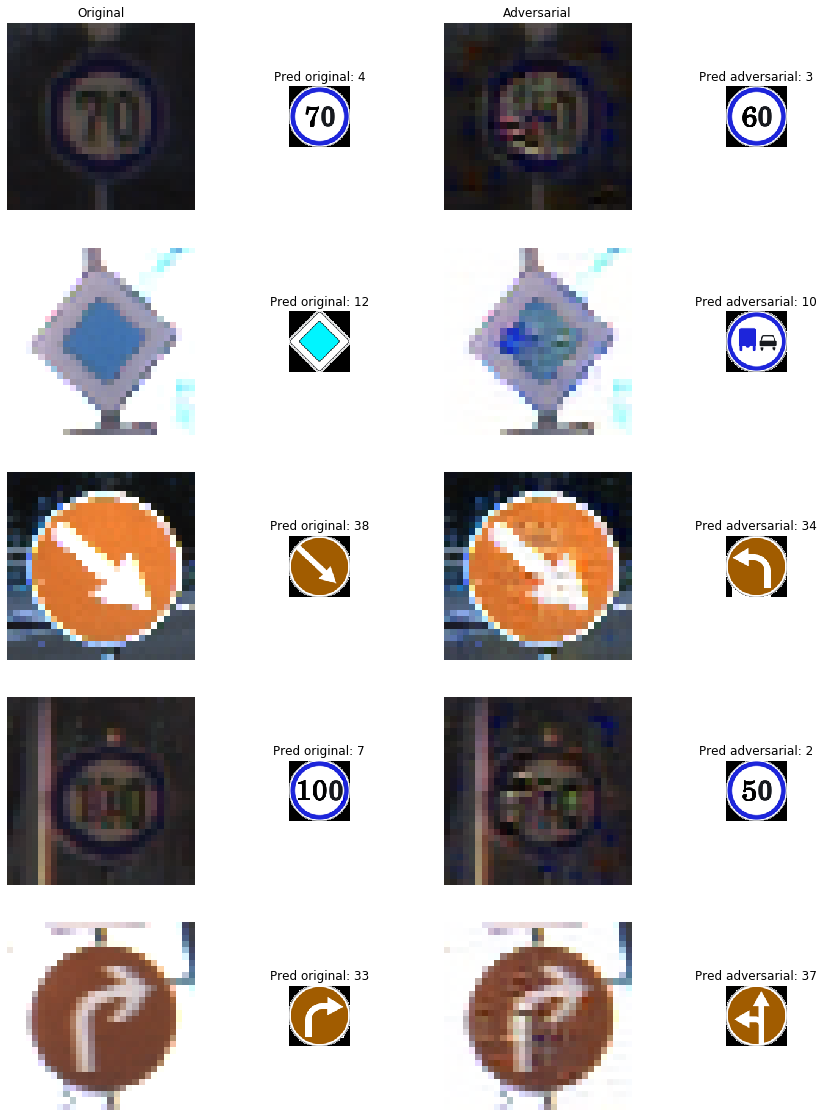

In [16]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (30, 30, 3)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

# Detect Advs

In [17]:
X = np.concatenate([X_to_adv, X_adv], axis=0)
print(X.shape)

(1000, 30, 30, 3)


In [18]:
ad_preds = ad.predict(X, return_instance_score=True)

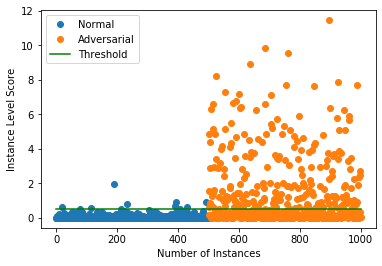

In [19]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)

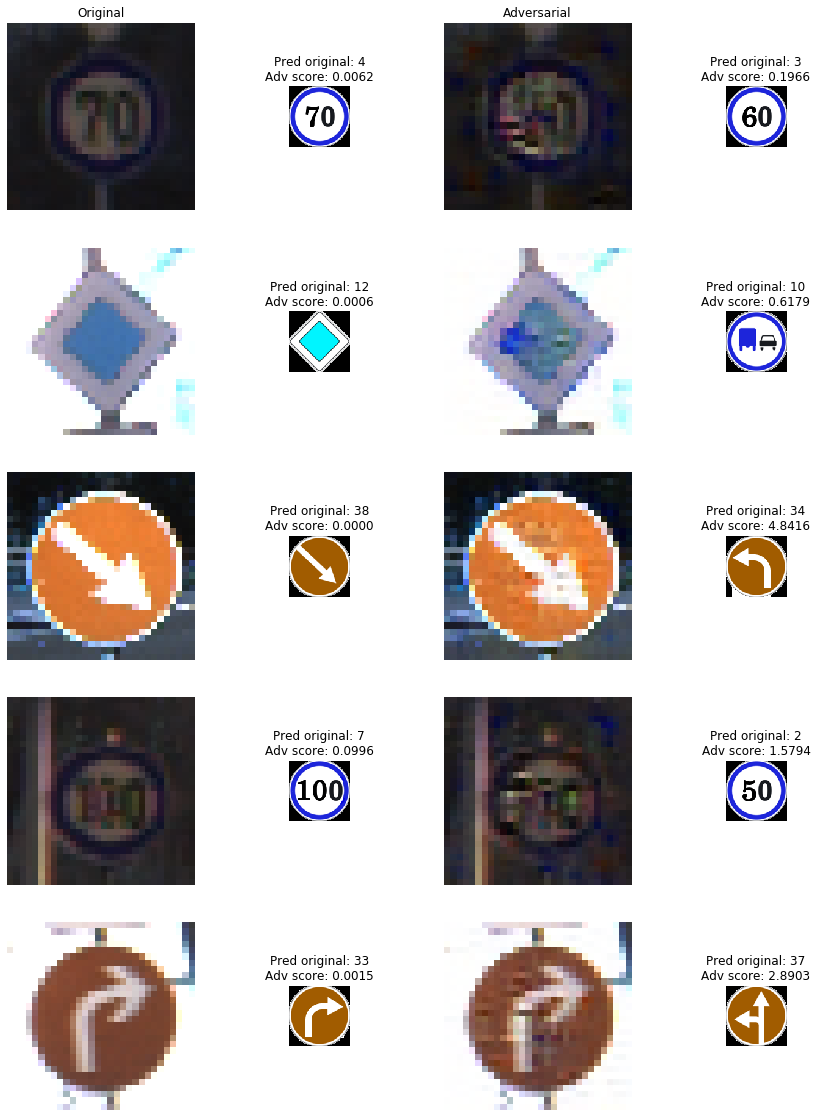

In [20]:
scores = ad_preds['data']['instance_score']
fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')  
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    image = Image.fromarray(class_image, 'RGB')
    image = np.array(image)
    ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[row], scores[row]))    
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    image_adv = Image.fromarray(class_image_adv, 'RGB')
    image_adv = np.array(image_adv)   
    ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred original: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[row], scores[row + nb_adv]))    
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

# Adversarial detection performances

In [21]:
kl_test_dict = ad.predict(X_to_adv, return_instance_score=True)
kl_test = kl_test_dict['data']['instance_score']
kl_adv_dict = ad.predict(X_adv, return_instance_score=True)
kl_adv = kl_adv_dict['data']['instance_score']

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [22]:
print(kl_test.shape, kl_adv.shape)
print(kl_test.mean(), kl_test.std())
print(kl_adv.mean(), kl_adv.std())

(500,) (500,)
0.074517466 0.16223368
1.3403553 1.9577397


In [23]:
preds_ad_test = kl_test_dict['data']['is_adversarial']
preds_ad_adv = kl_adv_dict['data']['is_adversarial']
preds_ad = np.concatenate((preds_ad_test, preds_ad_adv))
y_true_ad = np.concatenate((np.zeros(len(preds_ad_test)), np.ones(len(preds_ad_adv))))

In [24]:
print('Adversarial detection accuracy:', accuracy_score(y_true_ad, preds_ad))


Adversarial detection accuracy: 0.721


In [25]:
print('Adversarial detection f1:', f1_score(y_true_ad, preds_ad))

Adversarial detection f1: 0.6244952893674294


## Curves

In [26]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

def predict_fn(x):
    return model.predict(x)

In [27]:
perm = np.random.permutation(range(len(kl_adv)))[:500]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [28]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_to_adv, X_adv, predict_fn, nb_samples=1000, nb_sigmas=5)
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

### Precision recall curves

Naive detector baseline


(0.0, 1.0)

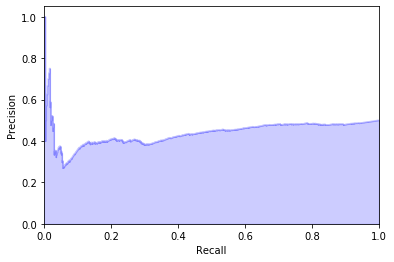

In [29]:
print('Naive detector baseline')
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Vae detector


(0.0, 1.0)

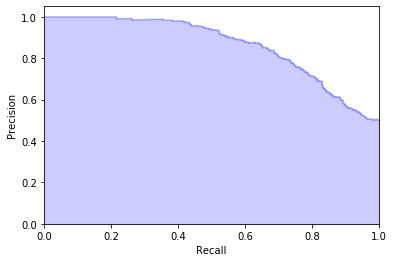

In [30]:
print('Vae detector')
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

### Accuracy - f1 scores

In [31]:
trs = np.arange(0, 1.001, 0.001)
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fdz/anaconda3/envs/tf2-gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy


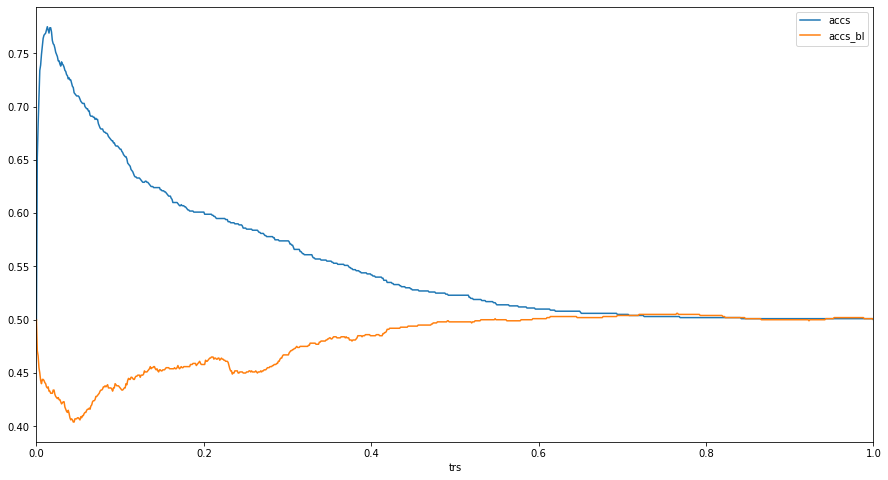

In [32]:
print('Accuracy')
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

F1 score


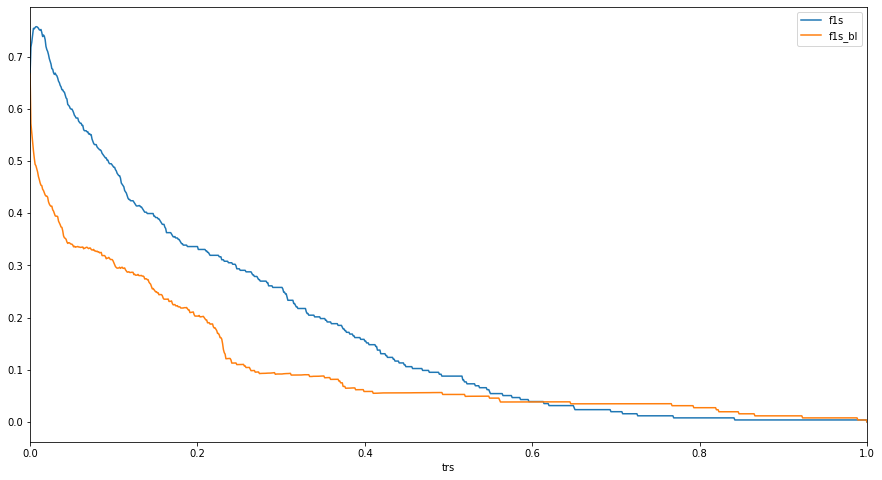

In [33]:
print('F1 score')
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [34]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.500000,0.990770,0.113231,0.553151,0.172516,0.498217,0.077590,0.481844,0.103764
std,0.289108,0.048692,0.154738,0.066508,0.197128,0.163834,0.113891,0.026414,0.117103
min,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.404000,0.000000
25%,0.250000,1.000000,0.006000,0.503000,0.011928,0.388889,0.018000,0.459000,0.034884
50%,0.500000,1.000000,0.046000,0.523000,0.087954,0.466667,0.028000,0.498000,0.052830
75%,0.750000,1.000000,0.172000,0.585000,0.293515,0.588235,0.068000,0.502000,0.110211
max,1.000000,1.000000,1.000000,0.775000,0.757243,1.000000,1.000000,0.506000,0.666667


### Distributions

Vae detector


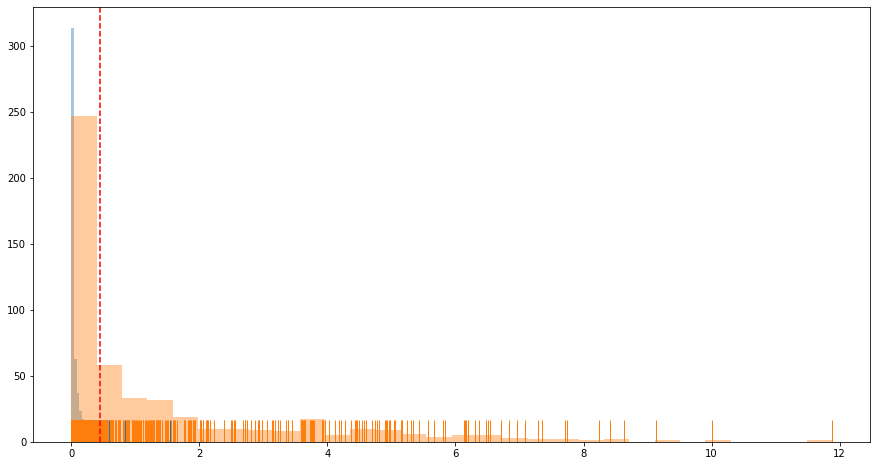

In [35]:
print('Vae detector')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

Naive detector baseline


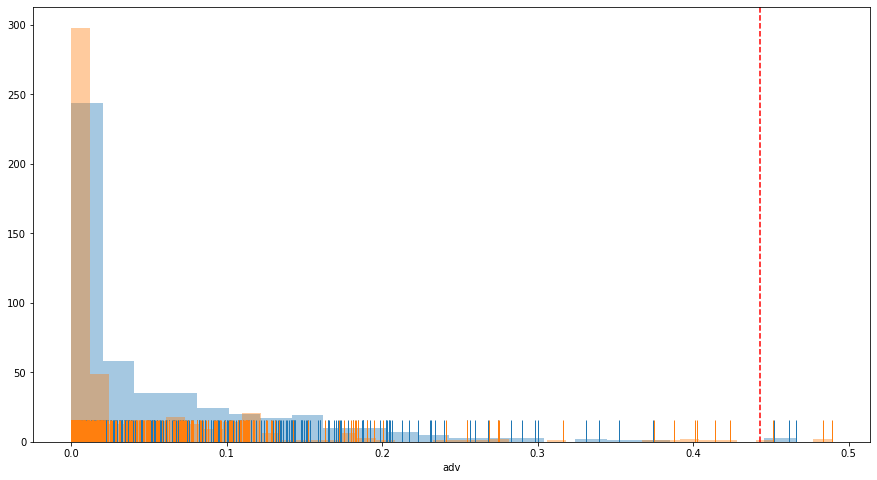

In [36]:
print('Naive detector baseline')
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)